In [9]:
import os
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import random
import librosa
import pickle

import torch

import warnings
warnings.filterwarnings('ignore')

In [10]:
class Config:
    SR = 32000
    N_MFCC = 13
    # Dataset
    ROOT_FOLDER = './'
    # Training
    N_CLASSES = 2
    BATCH_SIZE = 16
    N_EPOCHS = 5
    LR = 3e-4
    # Others
    SEED = 42
    
CONFIG = Config()

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED) # Seed 고정

In [4]:
df = pd.read_csv('./data/train.csv')
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, random_state=CONFIG.SEED)

# Get Features

In [5]:
def get_mfcc_feature(df, train_mode=True):
    features = []
    labels = []
    for _, row in tqdm(df.iterrows()):
        y, sr = librosa.load(row['path'], sr=CONFIG.SR)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CONFIG.N_MFCC)
        mfcc = np.mean(mfcc.T, axis=0)
        features.append(mfcc)

        if train_mode:
            label = row['label']
            label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
            label_vector[0 if label == 'fake' else 1] = 1
            labels.append(label_vector)

    if train_mode:
        return features, labels
    return features

In [ ]:
train_mfcc_features, train_mfcc_labels = get_mfcc_feature(train, True)
val_mfcc_features, val_mfcc_labels = get_mfcc_feature(val, True)

In [ ]:
print(type(train_mfcc_features), type(train_mfcc_labels))
print(train_mfcc_features)
print(train_mfcc_labels)

In [ ]:
with open('data/features/train_mfcc_features.pkl', 'wb') as f:
    pickle.dump(train_mfcc_features, f)
with open('data/features/train_mfcc_labels.pkl', 'wb') as f:
    pickle.dump(train_mfcc_labels, f)
with open('data/features/val_mfcc_features.pkl', 'wb') as f:
    pickle.dump(val_mfcc_features, f)
with open('data/features/val_mfcc_labels.pkl', 'wb') as f:
    pickle.dump(val_mfcc_labels, f)

In [ ]:
def get_melspec_feature(df, train_mode=True):
    features = []
    labels = []
    for _, row in tqdm(df.iterrows()):
        y, sr = librosa.load(row['path'], sr=CONFIG.SR)
        melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8192)   
        melspec_dB = librosa.power_to_db(melspec, ref=np.max)
        features.append(melspec_dB)

        if train_mode:
            label = row['label']
            label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
            label_vector[0 if label == 'fake' else 1] = 1
            labels.append(label_vector)

    if train_mode:
        return features, labels
    return features

In [ ]:
train_melspec_features, train_melspec_labels = get_melspec_feature(train, True)
val_melspec_features, val_melspec_labels = get_melspec_feature(val, True)

In [ ]:
with open('data/features/train_melspec_features.pkl', 'wb') as f:
    pickle.dump(train_melspec_features, f)
with open('data/features/train_melspec_labels.pkl', 'wb') as f:
    pickle.dump(train_melspec_labels, f)
with open('data/features/val_melspec_features.pkl', 'wb') as f:
    pickle.dump(val_melspec_features, f)
with open('data/features/val_melspec_labels.pkl', 'wb') as f:
    pickle.dump(val_melspec_labels, f)

In [ ]:
with open('data/features/train_mfcc_features.pkl', 'rb') as f:
    train_mfcc_features = pickle.load(f)
with open('data/features/train_mfcc_labels.pkl', 'rb') as f:
    train_mfcc_labels = pickle.load(f)
with open('data/features/val_mfcc_features.pkl', 'rb') as f:
    val_mfcc_features = pickle.load(f)
with open('data/features/val_mfcc_labels.pkl', 'rb') as f:
    val_mfcc_labels = pickle.load(f)

In [ ]:
with open('data/features/train_melspec_features.pkl', 'rb') as f:
    train_melspec_features = pickle.load(f)
with open('data/features/train_melspec_labels.pkl', 'rb') as f:
    train_melspec_labels = pickle.load(f)
with open('data/features/val_melspec_features.pkl', 'rb') as f:
    val_melspec_features = pickle.load(f)
with open('data/features/val_melspec_labels.pkl', 'rb') as f:
    val_melspec_labels = pickle.load(f)

# Visualize

In [ ]:
def mfcc_visualize(csv_path, save_path):
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    os.makedirs(save_path)

    df = pd.read_csv(csv_path)

    for i in tqdm(range(len(df))):
        image_data = df.loc[i]

        y, sr = librosa.load(os.path.join('data', image_data['path']), sr=CONFIG.SR)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CONFIG.N_MFCC)

        plt.figure(figsize=(8, 4))
        librosa.display.specshow(mfccs, x_axis='time')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"{save_path}/{image_data['id']}.png", dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

In [ ]:
# mfcc_visualize(csv_path="data/train_answer.csv", save_path="data/train_mfcc")
# mfcc_visualize(csv_path="data/val_answer.csv", save_path="data/val_mfcc")
# mfcc_visualize(csv_path="data/test.csv", save_path="data/test_mfcc")

In [ ]:
def melspec_visualize(csv_path, save_path):
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    os.makedirs(save_path)

    df = pd.read_csv(csv_path)

    for i in tqdm(range(len(df))):
        image_data = df.loc[i]

        y, sr = librosa.load(os.path.join('data', image_data['path']), sr=32000)
        melspecs = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8192)  # n_mels: 멜 필터의 개수, fmax: 주파수 최대값
        melspecs_db = librosa.power_to_db(melspecs, ref=np.max)

        plt.figure(figsize=(8, 4))
        librosa.display.specshow(melspecs_db, x_axis='time', y_axis='mel', sr=sr, fmax=8192)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f"{save_path}/{image_data['id']}.png", dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

In [ ]:
# melspec_visualize(csv_path="train_answer.csv", save_path="train_melspec")
# melspec_visualize(csv_path="val_answer.csv", save_path="val_melspec")
# melspec_visualize(csv_path="data/test.csv", save_path="data/test_melspec")

# Data preprocessing

In [18]:
import soundfile as sf
audio_path1 = 'data/train/RUNQPNJF.ogg'
audio_path2 = 'data/train/RDKEKEVX.ogg'

y1, sr1 = librosa.load(audio_path1, sr=32000)
y2, sr2 = librosa.load(audio_path2, sr=32000)

max_length = max(len(y1), len(y2))
y1 = np.pad(y1, (0, max_length - len(y1)), 'constant')
y2 = np.pad(y2, (0, max_length - len(y2)), 'constant')

y = y1 + y2

S = librosa.feature.melspectrogram(y=y, sr=sr1, n_mels=128, fmax=8192)
S_dB = librosa.power_to_db(S, ref=np.max)

sf.write("example/combine_sound.ogg", y, sr1)

In [19]:
print(S_dB.shape)

(128, 385)


In [24]:
image_data = pd.read_csv('data/train_answer.csv')
if 'label' in image_data.columns:
    print(1)
else:
    print(0)

1


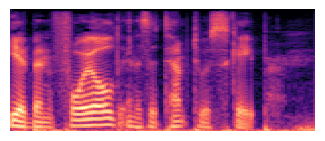

In [62]:
# Mel Spectrogram visualize example

audio_path1 = 'data/train/RUNQPNJF.ogg'
audio_path2 = 'data/train/RDKEKEVX.ogg'
audio_path3 = 'example/combine_sound.ogg'

y1, sr1 = librosa.load(audio_path1, sr=32000)
y2, sr2 = librosa.load(audio_path2, sr=32000)
y3, sr3 = librosa.load(audio_path3, sr=32000)
S1 = librosa.feature.melspectrogram(y=y1, sr=sr1, n_mels=128, fmax=8192)
S2 = librosa.feature.melspectrogram(y=y2, sr=sr2, n_mels=128, fmax=8192)
S3 = librosa.feature.melspectrogram(y=y3, sr=sr3, n_mels=128, fmax=8192)
S_dB1 = librosa.power_to_db(S1, ref=np.max)
S_dB2 = librosa.power_to_db(S2, ref=np.max)
S_dB3 = librosa.power_to_db(S3, ref=np.max)

plt.figure(figsize=(4, 2))
librosa.display.specshow(S_dB1, x_axis='time', y_axis='mel', sr=sr1, fmax=8192)
plt.tight_layout()
plt.axis("off")
plt.savefig(f'./example/melspec_{os.path.splitext(os.path.basename(audio_path1))[0]}.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

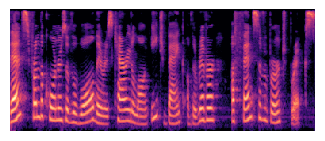

In [63]:
plt.figure(figsize=(4, 2))
librosa.display.specshow(S_dB2, x_axis='time', y_axis='mel', sr=sr2, fmax=8192)
plt.tight_layout()
plt.axis("off")
plt.savefig(f'./example/melspec_{os.path.splitext(os.path.basename(audio_path2))[0]}.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

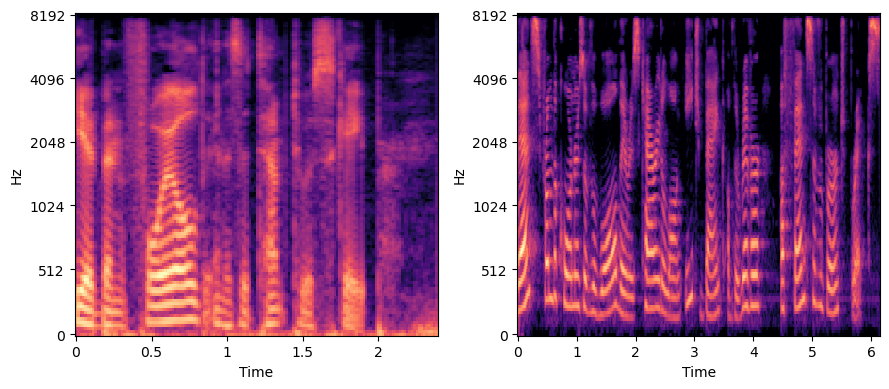

In [64]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
librosa.display.specshow(S_dB1, x_axis='time', y_axis='mel', sr=sr1, fmax=8192)
plt.tight_layout()

plt.subplot(122)
librosa.display.specshow(S_dB2, x_axis='time', y_axis='mel', sr=sr2, fmax=8192)
plt.tight_layout()

plt.show()
plt.close()

In [65]:
max_length = max(len(y1), len(y2))
y1 = np.pad(y1, (0, max_length - len(y1)), 'constant')
y2 = np.pad(y2, (0, max_length - len(y2)), 'constant')
y = y1 + y2

S = librosa.feature.melspectrogram(y=y, sr=32000, n_mels=128, fmax=8192)
S_dB = librosa.power_to_db(S, ref=np.max)

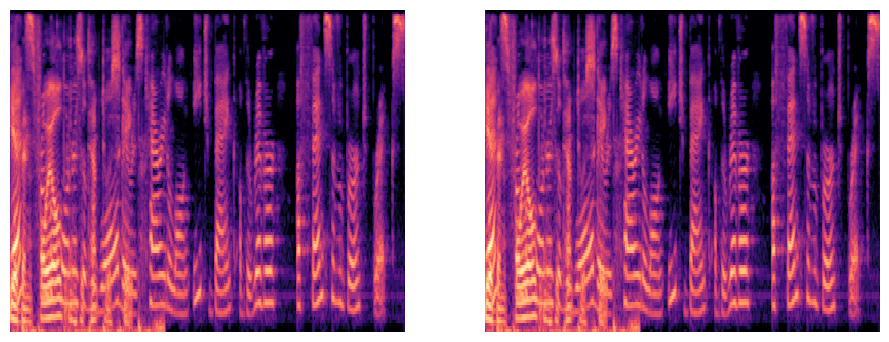

In [66]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
librosa.display.specshow(S_dB3, x_axis='time', y_axis='mel', sr=32000, fmax=8192)
plt.tight_layout()
plt.axis("off")

plt.subplot(122)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=32000, fmax=8192)
plt.tight_layout()
plt.axis("off")

plt.show()
plt.close()

# Modify dataset.py for data argumentation

In [ ]:
import os

import pandas as pd
import numpy as np
from PIL import Image
import random

from torch.utils.data import Dataset

from src.utils import Config

CONFIG = Config()

class VoiceDataset(Dataset):
    def __init__(self, image_path, csv_path, transform, mode):
        self.image_path = image_path
        self.csv_data = pd.read_csv(csv_path)
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, index):
        image_data = self.csv_data.loc[index]
        
        argument = random.choice([0, 1]) # test 및 valid 때 안해야됨

        if argument == 0:
            image = Image.open(os.path.join(self.image_path, f"{image_data['id']}.png")).convert('RGB')
            image = np.array(image, dtype=np.float32)
            image = self.transform(image)

        else:
            audio1 = os.path.join('data', image_data['path'])
            audio2 = os.path.join('data', ) # random한 unlabeled_data 넣어야 함
            y1, _ = librosa.load(audio1, sr=CONFIG.SR)
            y2, _ = librosa.load(audio2, sr=CONFIG.SR)
            max_length = max(len(y1), len(y2))
            y1 = np.pad(y1, (0, max_length - len(y1)), 'constant') # padding 위치 random하게 수정 필요
            y2 = np.pad(y2, (0, max_length - len(y2)), 'constant')
            y = y1 + y2
            S = librosa.feature.melspectrogram(y=y, sr=CONFIG.SR, n_mels=CONFIG.N_MELS, fmax=8192)
            S_dB = librosa.power_to_db(S, ref=np.max)

            plt.figure(figsize=(8, 4))
            librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=32000, fmax=8192)
            plt.tight_layout()
            plt.axis("off")
            plt.savefig(f'data/argument/comb_{image_data['id']}.png', dpi=300, bbox_inches='tight', pad_inches=0)
            plt.close()
            
        if 'label' in self.csv_data.columns:
            if self.mode == "real":
                label = np.array([0, 1] if image_data['label'] == 'real' else [1, 0], dtype=np.float32)
            elif self.mode == "fake":
                label = np.array([0, 1] if image_data['label'] == 'fake' else [1, 0], dtype=np.float32)
            return image, label
        else:
            return image

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image1 = cv2.imread('data/train_melspec/RUNQPNJF.png')
image2 = cv2.imread('data/train_melspec/RDKEKEVX.png')

h = max(image1.shape[0], image2.shape[0])
w = max(image1.shape[1], image1.shape[1])
image1_resized = cv2.resize(image1, (w, h))
image2_resized = cv2.resize(image2, (w, h))

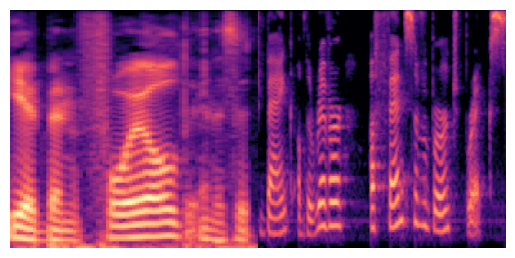

In [80]:
combined_image = np.zeros_like(image1_resized)
combined_image[:, :w//2] = image1_resized[:, :w//2]
combined_image[:, w//2:] = image2_resized[:, w//2:]

cv2.imwrite('example/combine_image.png', combined_image)

plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

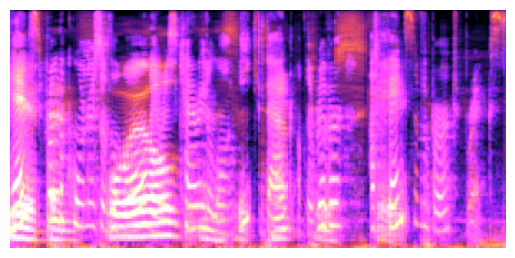

In [87]:
alpha = 0.5
blended_image = cv2.addWeighted(image1_resized, 1, image2_resized, 1, 0)

cv2.imwrite('example/blended_image.png', blended_image)

plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show

In [90]:
import glob
data = glob.glob("data/unlabeled_data/*.ogg")
print(len(data))
print(data[0])

1264
data/unlabeled_data\ABJGMLHQ.ogg


In [102]:
submit = pd.read_csv('submitfile/effi_5epoch_melspec_sepa.csv')
submit['fake'] = submit['fake'].apply(lambda x: 0 if x < 0.5 else (1 if x > 0.5 else x))
submit['real'] = submit['real'].apply(lambda x: 0 if x < 0.5 else (1 if x > 0.5 else x))
submit.head()

,id,fake,real
0,TEST_00000,0,1
1,TEST_00001,0,1
2,TEST_00002,0,1
3,TEST_00003,0,1
4,TEST_00004,0,1


In [103]:
submit.to_csv('submitfile/effi_5epoch_melspec_sepa_binary.csv', index=False)